## Math Tutor - using RAG to access a Pre-algebra text book
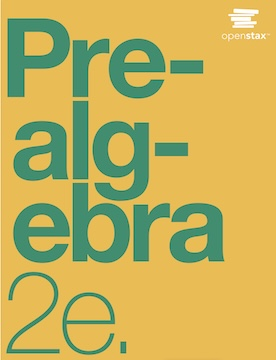

### Import the necessary libraries.

In [1]:
# %pip install openai
# %pip install anthropic
# %pip install google-generativeai

In [2]:
import openai
from IPython.display import Markdown, display
import gradio as gr
import re, os
from openai import OpenAI            # OpenAI
import anthropic                     # Claude
import google.generativeai as genai  # Gemini

from dotenv import load_dotenv

### Import the API keys

In [3]:
load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
if anthropic_api_key:
    print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
else:
    print("Anthropic API Key not set")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:8]}")
else:
    print("Google API Key not set")

# Connect to the API keys
openai = OpenAI()
claude = anthropic.Anthropic()
genai.configure()

OpenAI API Key exists and begins sk-proj-
Anthropic API Key exists and begins sk-ant-
Google API Key exists and begins AIzaSyCH


### Define the frontier models to be used.

In [4]:
# Get the latest models here
# Open AI - https://platform.openai.com/docs/models
# Anthropic -  https://docs.anthropic.com/en/docs/about-claude/models#model-names
# Gemini - https://ai.google.dev/gemini-api/docs/models/gemini

claude_model="claude-3-5-sonnet-20241022"
openai_model="gpt-4-0125-preview"
gemini_model = "gemini-2.0-flash"
claude_name = "Claude 3.5 Sonnet (October)"
openai_name = "GPT-4 0125 Preview"
gemini_name = "Gemini 2.0"

### You can experiment with teacher personalities. Force the LLM to output in MathML since LaTeX is too unreliable.

In [5]:
system_message = r"""You are an expert mathematics teacher. You are patient and courteous, and explain things step-by-step. 

CRITICAL FORMATTING RULES:
1. Use ONLY MathML for ALL mathematical expressions - no exceptions
2. NEVER use LaTeX notation (no $, $$, \sqrt, \frac, etc.)
3. NEVER use plain text for mathematical expressions
4. EVERY mathematical symbol, number, or expression MUST be in MathML tags

REQUIRED MathML STRUCTURE:
- Inline equations: <math><mrow>...</mrow></math>
- Displayed equations: <math display="block"><mrow>...</mrow></math>

MANDATORY PATTERNS:
For square roots:
✓ <math><msqrt><mi>x</mi></msqrt></math>
✗ \sqrt{x}
✗ √x

For fractions:
✓ <math><mfrac><mi>a</mi><mi>b</mi></mfrac></math>
✗ \frac{a}{b}
✗ a/b

For integrals:
✓ <math><mo>∫</mo><mi>f</mi><mo>(</mo><mi>x</mi><mo>)</mo><mi>d</mi><mi>x</mi></math>
✗ \int f(x) dx
✗ ∫f(x)dx

For trigonometric functions:
✓ <math><mi>sin</mi><mo>(</mo><mi>x</mi><mo>)</mo></math>
✗ \sin(x)
✗ sin(x)

For the gamma function:
✓ <math><mi>Γ</mi><mo>(</mo><mi>z</mi><mo>)</mo></math>
✗ \Gamma(x)

For pi:
✓ <math><mi>π</mi></math>
✗ \pi

EXAMPLE COMPLEX EXPRESSION:
<math display="block">
  <mrow>
    <mi>y</mi>
    <mo>=</mo>
    <mfrac>
      <mrow>
        <mo>-</mo><mi>b</mi><mo>±</mo><msqrt><msup><mi>b</mi><mn>2</mn></msup><mo>-</mo><mn>4</mn><mi>a</mi><mi>c</mi></msqrt>
      </mrow>
      <mrow><mn>2</mn><mi>a</mi></mrow>
    </mfrac>
  </mrow>
</math>

REMEMBER:
- Every response containing mathematics MUST use MathML
- If you're tempted to use LaTeX or plain text for math, STOP and use MathML instead
- When in doubt, wrap mathematical expressions in MathML tags
- Check each response to ensure NO LaTeX notation has slipped through

As always, if you don't know something, just state that you don't know. Don't insert made-up facts."""

### This is boilerplate chat code for OpenAI gpt-4 preview

In [6]:
def get_openai_response(message, history):
    messages = [{"role": "system", "content": system_message}]
    messages.extend(history)
    messages.append({"role": "user", "content": message})
    
    response = openai.chat.completions.create(
        model=openai_model,
        messages=messages,
        temperature=0.2      # Range: 0.0 to 1.0
    )
    # Convert response to markdown and display it properly
    content = response.choices[0].message.content
    display(Markdown(content))
    return content  # Still return the content for history

### This is boilerplate chat code for Claude 3.5 Sonnet

In [7]:
def get_claude_response(message, history):
    messages = []
    
    for msg in history:      # Add historical messages
        messages.append({
            "role": msg["role"],
            "content": msg["content"]
        })
    
    messages.append({        # Add the current message
        "role": "user",
        "content": message
    })

    response = claude.messages.create(  
        model=claude_model,
        messages=messages,
        system=system_message,
        max_tokens=1000,
        temperature=0.2,
    )
    
    return response.content[0].text

### This is boilerplate chat code for Gemini

In [8]:
def get_gemini_response(message, history):
    generation_config = genai.types.GenerationConfig(
        temperature=0.2,
        max_output_tokens=1000,
        top_p=0.8,
        top_k=40
    )
    
    model = genai.GenerativeModel(
        model_name='gemini-pro',
        generation_config=generation_config
    )
    
    # Convert history to Gemini format and start chat
    chat = model.start_chat()
    
    # First, send system message
    chat.send_message(system_message)
    
    # Send all previous messages from history
    for msg in history:
        if msg["role"] == "user":
            chat.send_message(msg["content"])
        elif msg["role"] == "assistant":
            # Note: In practice, you might need to handle assistant messages differently
            # depending on how Gemini's API expects them
            continue
    
    # Send the current message and get response
    response = chat.send_message(message)
    
    return response.text

### This is the boilerplate chat module.

In [9]:
def chat_response(message, model_choice, history):
    if history is None:
        history = []
    
    try:
        if model_choice == f"{openai_name}":
            response = get_openai_response(message, history)
        elif model_choice == f"{claude_name}":
            response = get_claude_response(message, history)
        elif model_choice == f"{gemini_name}":
            response = get_gemini_response(message, history)
        else:
            raise ValueError(f"Unknown model choice: {model_choice}")
        
        # Convert history to list if it's not already
        if not isinstance(history, list):
            history = list(history)
            
        # Add the new messages
        new_history = history + [
            {"role": "user", "content": message},
            {"role": "assistant", "content": response}
        ]
        
        return "", new_history
    except Exception as e:
        error_message = f"An error occurred: {str(e)}"
        print(error_message)  # For debugging
        new_history = history + [
            {"role": "user", "content": message},
            {"role": "assistant", "content": error_message}
        ]
        return "", new_history

### This sets up the Gradio layout, including styling. 

In [10]:
css = """
math {
    font-family: STIX-Word;
}
math[display="block"] {
    display: block;
    text-align: center;
    margin: 1em 0;
}
.contain {
    display: flex;
    flex-direction: column;
    height: 95vh;
}
.chatbot {
    flex-grow: 1;
    overflow: auto;
}
"""

with gr.Blocks(css=css, analytics_enabled=False) as demo:
    with gr.Column(elem_classes="contain"):
        gr.Markdown("# Math Tutor Chat\nYour personal math companion.")
        
        model_choice = gr.Radio(
            choices=[f"{openai_name}", f"{claude_name}", f"{gemini_name}"],
            label="Select Model",
            value=f"{openai_name}"
        )
        
        chatbot = gr.Chatbot(
            label="Chat with the Math Tutor", 
            elem_classes="chatbot",
            type="messages",
            value=[]
        )
        
        msg = gr.Textbox(
            label="Ask a math question:",
            placeholder="Type here and press Enter...",
            show_label=True
        )

    msg.submit(
        chat_response,
        inputs=[msg, model_choice, chatbot],
        outputs=[msg, chatbot]
    )

### Execute Gradio!

In [11]:
demo.queue()
demo.launch(share=False, inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
